In [1]:
import pandas as pd
import numpy as np

In [2]:
import re

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from datetime import datetime
from difflib import get_close_matches

In [5]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from sklearn.metrics import f1_score

In [6]:
from xgboost import XGBClassifier, XGBRegressor, plot_importance

In [7]:
from sklearn.utils import shuffle

In [8]:
# BTCUSD_1H = pd.read_csv('../data/Binance_BTCUSDT_1h.csv', skiprows=1)

In [9]:
df_ETHUSD_1min = pd.read_parquet('../ETH-USDT.parquet')

In [10]:
df_ETHUSD_1min = df_ETHUSD_1min.sort_index(ascending=True)

In [11]:
# df_ETHUSD_1min['avg'] = df_ETHUSD_1min['quote_asset_volume']/df_ETHUSD_1min['volume']

low and high are different for different rolling averages, therefore, there should be 2 segment-paris (or 4 segments for):

> bull low v ra <br/> bull high v ra <br/> bear low v ra <br/>  bear high v ra
    
    
e.g. in a bull market, low ticker vs rolling average of X (this X needs to be found)
(expect abs(low-ra | bull) < abs(low-ra | bear)  :: absolute value of low minus ra give bull => abs(low-ra | bull)

In [12]:
# df_ETHUSD_1min.drop(['volume',
#              'quote_asset_volume',
#              'number_of_trades',
#              'taker_buy_base_asset_volume',
#              'taker_buy_quote_asset_volume'],
#             axis = 1,
# #             inplace=True
#                    )

In [13]:
agg_grouping = {'open':'first',
                'high':'max',
                'low':'min',
                'close':'last',
                'volume':'sum',
                'quote_asset_volume':'sum',
                'open_time':['min','max','count']
               }


In [14]:
def open_time_refine(txt):
    if txt[0] != 'open_time':
        return txt[0]
    
    else:
        return txt[0] + '_' +txt[1]

In [15]:
def window_groupby(df, grouper_key, freq, agg_grouping):
    
    df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
    
    if 'open_time' in agg_grouping.keys():
        df_temp.columns = [open_time_refine(col) for col in df_temp.columns]
    
    df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
    
    return df_temp

In [16]:
df_15min = window_groupby(df=df_ETHUSD_1min,
                       grouper_key='open_time',
                       freq='15min',
                       agg_grouping=agg_grouping
                         )

In [17]:
def add_rolling_averges(df, list_to_add_unit_hour, index_unit):
    """
    INPUT:
    df - dataframe (assume the datafram is already sorted)
    list_to_add_unit_hour - list of rolling averages to add in the unit of hour, e.g.
                            list_to_add_unit_hour = [1, 2, 4] , will produce R.As of
                            1H, 2H, 4H (window calculated by dividing by the index_unit)
                            
    index_unit - unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)
    
    OUTPUT:
    dataframe with added rolling averages
    """
    df_temp = df
    
    rows = float(index_unit.replace('min',''))/60
    
    for ra in list_to_add_unit_hour:
        
        df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()
    
    return df_temp

In [87]:
df_prepare = add_rolling_averges(df_15min, [1,2,4], '15min').dropna(axis=0).copy(deep=True)

In [88]:
df_prepare['y_avg'] = df_prepare['avg'].shift(-1)

In [89]:
df_prepare['y_low'] = 100 * ((df_prepare['low'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_high'] = 100 * ((df_prepare['high'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_avg'] = 100 * ((df_prepare['avg'].shift(-1) - df_prepare['avg'])/df_prepare['avg'])

2 approaches to try here:
> 1. engineer some features and use typical ML mode
> 2. remove most of the features (ra etc) and input into a neural network

predict low and high:
> if high reached first, cancel the position (since high --> low situation) <br/>
> want low to arrive first (since low --> high situation)

(**thinking about this**) <br/>
for each approach, need to train 2 models:
> model_1_low: first training, predict the low <br/>
> model_2_higih: second training, with the low_pred value from the model before, predict the high

### Traditional Approach

first to train a model to predict the lows and highs in the next 15minutes

In [91]:
def normalising_data(df, columns, base):
    """
    INPUT:
    df - dataframe to normalise
    columns - list of columns to be normalised (column/base)
    base - name of the normalised base (denominator)
    
    
    OUTPUT:
    df - normalised dataframe
    """
    assert base not in columns, "base should not be in the list of columns, as it will be dividing by 0"
    
    df_temp = df.copy(deep=True)
    
    for col in columns:
        df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[base]) - 1)
    
    return df_temp

In [111]:
base = 'ra_1H'
columns_to_norm = [d for d in ['open','high','low','close','avg','ra_1H','ra_2H','ra_4H'] if d != base]
y_columns = ['y_avg','y_low','y_high']

In [112]:
df_normalised = normalising_data(df_prepare, columns=columns_to_norm, base=base)

In [114]:
## preparing dataframe for training
df_input = df_normalised[columns_to_norm + y_columns].copy(deep=True)

In [115]:
df_input = df_input[:-1]

In [116]:
df_input_set_aside = df_input[-17000:].copy(deep=True)

In [117]:
df_input_traintest = df_input[:-17000].copy(deep=True)

In [118]:
df_input_traintest = shuffle(df_input_traintest)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(df_input_traintest[columns_to_norm].values, 
                                                    df_input_traintest[['y_avg','y_low','y_high']].values ,
                                                    train_size=0.70,
                                                    random_state=42)

In [124]:
y_train

array([-1.0234627 , -0.61181164,  0.9770703 ], dtype=float32)

In [125]:
y_train_avg = y_train[:,0]
y_train_low = y_train[:,1]
y_train_high = y_train[:,2]

y_test_avg = y_test[:,0]
y_test_low = y_test[:,1]
y_test_high = y_test[:,2]

In [126]:
pipeline_xgb_avg_rel = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])


pipeline_xgb_low = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])

pipeline_xgb_high = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])


> try different learning rates (0.08 is the best so far)

In [127]:
pipeline_xgb_avg_rel.fit(X_train, y_train_avg)
pipeline_xgb_low.fit(X_train, y_train_low)
pipeline_xgb_high.fit(X_train, y_train_high)

/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Pipeline(steps=[('multi_clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=12, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.75,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [128]:
y_pred_avg = pipeline_xgb_avg_rel.predict(X_test)
y_pred_low = pipeline_xgb_low.predict(X_test)
y_pred_high = pipeline_xgb_high.predict(X_test)

pipeline_xgb_avg_rel._final_estimator.feature_importances_
pipeline_xgb_low._final_estimator.feature_importances_
pipeline_xgb_high._final_estimator.feature_importances_

In [129]:
y_pred_low

array([-0.30922097, -0.29865402, -0.18592359, ..., -0.42976528,
       -0.15823592, -0.5902675 ], dtype=float32)

In [ ]:
)

In [166]:
## naive prediction
sum(abs(np.append(np.array([0.16655789]),y_test_avg)[:-1] - y_test_avg))/len(y_test_avg)

0.46586594381013174

In [167]:
sum(abs(y_pred_avg - y_test_avg))/len(y_pred_avg)

0.24536526182156856

In [168]:
sum(abs(y_pred_low - y_test_low))/len(y_test_low)

0.1555974651859939

In [169]:
sum(abs(y_pred_high - y_test_high))/len(y_test_low)

0.15694326098503328

In [171]:
y_pred_avg_unseen = pipeline_xgb_avg_rel.predict(df_input_set_aside[columns_to_norm].values)
y_pred_low_unseen = pipeline_xgb_low.predict(df_input_set_aside[columns_to_norm].values)
y_pred_high_unseen = pipeline_xgb_high.predict(df_input_set_aside[columns_to_norm].values)

In [172]:
sum(abs(y_pred_low_unseen - df_input_set_aside['y_low'].values))/len(df_input_set_aside)

0.12379686146799256

In [173]:
sum(abs(y_pred_high_unseen - df_input_set_aside['y_high'].values))/len(df_input_set_aside)

0.12195271166107234

In [176]:
df_input_set_aside['pred_y_avg'] = y_pred_avg_unseen
df_input_set_aside['pred_y_low'] = y_pred_low_unseen
df_input_set_aside['pred_y_high'] = y_pred_high_unseen

In [ ]:
### continue here

In [197]:
df_input_set_aside

,open,high,low,close,avg,ra_2H,ra_4H,y_avg,y_low,y_high,pred_y_low,pred_y_high,pred_y_avg
open_time,,,,,,,,,,,,,
2020-07-05 04:00:00,0.056864,0.118240,-0.048348,-0.035197,0.036575,0.010673,0.228604,-0.082986,-0.058928,0.072655,-0.142248,0.147808,-0.057132
2020-07-05 04:15:00,-0.043062,0.022700,-0.108818,-0.025523,-0.049919,-0.039900,0.184051,-0.024997,-0.077814,0.097676,-0.134758,0.133254,0.018110
2020-07-05 04:30:00,-0.010542,0.037688,-0.137698,-0.054390,-0.059930,-0.036454,0.162012,0.089724,-0.106023,0.078079,-0.155272,0.143000,-0.015860
2020-07-05 04:45:00,-0.036977,0.112109,-0.072056,0.077030,0.034003,-0.016647,0.137629,0.004541,-0.119320,0.082296,-0.143140,0.141604,0.013658
2020-07-05 05:00:00,0.071712,0.124328,-0.077372,0.010324,0.041998,0.009610,0.117044,-0.041720,-0.064479,0.067068,-0.147087,0.144392,-0.031078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 22:30:00,-0.085690,0.059024,-0.242812,0.047995,-0.105896,0.189503,0.162304,0.573928,-0.411984,0.184758,-0.181254,0.174627,0.127186
2020-12-29 22:45:00,-0.082146,0.511038,-0.087648,0.420206,0.325678,0.054681,0.076264,-0.066708,-0.338645,0.285952,-0.301818,0.284875,0.143304
2020-12-29 23:00:00,0.345342,0.471866,-0.153889,0.040023,0.185384,-0.055493,0.038943,-0.134920,-0.404695,0.451687,-0.272968,0.275617,-0.089878


In [216]:
def undo_normalising_data(df, columns, base):
    """
    INPUT:
    df - dataframe to normalise
    columns - list of columns to be normalised (column/base)
    base - name of the normalised base (denominator)
    
    
    OUTPUT:
    df - normalised dataframe
    """
#     assert base not in columns, "base should not be in the list of columns, as it will be dividing by 0"
    new_columns = [d for d in columns if d != base]
    
    df_temp = df.copy(deep=True)
    
    for col in new_columns:
        df_temp[col] = (1 + df_temp[col].astype(np.float)/100) * df_temp[base]
    
    return df_temp

In [217]:
df_validate_results = df_input_set_aside.merge(df_normalised[[base]], left_index=True, right_index=True, how='left')

In [218]:
df_validate_results.head(2)

,open,high,low,close,avg,ra_2H,ra_4H,y_avg,y_low,y_high,pred_y_low,pred_y_high,pred_y_avg,ra_1H
open_time,,,,,,,,,,,,,,
2020-07-05 04:00:00,0.056864,0.11824,-0.048348,-0.035197,0.036575,0.010673,0.228604,-0.082986,-0.058928,0.072655,-0.142248,0.147808,-0.057132,228.100288
2020-07-05 04:15:00,-0.043062,0.02270,-0.108818,-0.025523,-0.049919,-0.039900,0.184051,-0.024997,-0.077814,0.097676,-0.134758,0.133254,0.018110,228.108223


In [219]:
df_testing_model_results = undo_normalising_data(df_validate_results, ['open', 'high', 'low', 'close',
                                                                       'avg', 'ra_1H', 'ra_2H', 'ra_4H',
                                                                       'y_avg','y_low','y_high',
                                                                       'pred_y_avg','pred_y_low','pred_y_high'], base)

<AxesSubplot:xlabel='open_time'>

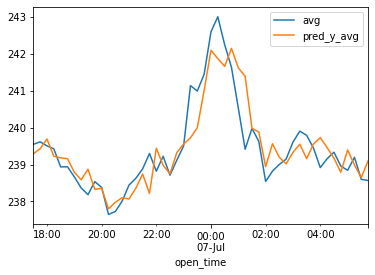

In [233]:
df_testing_model_results[[
#                           'high','pred_y_high', 
#                           'low','pred_y_low',
                          'avg','pred_y_avg'
                        ]][150:200].plot()

In [223]:
df_testing_model_results['high_diff_prec'] = 100 * (df_testing_model_results['pred_y_high'] - df_testing_model_results['y_high'])/df_testing_model_results['y_high']

In [224]:
df_testing_model_results['low_diff_prec'] = 100 * (df_testing_model_results['pred_y_low'] - df_testing_model_results['y_low'])/df_testing_model_results['y_low']

<AxesSubplot:>

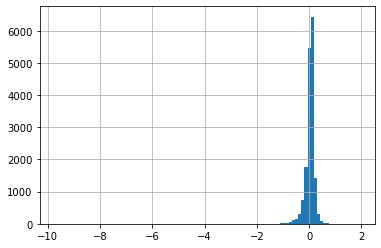

In [225]:
df_testing_model_results['high_diff_prec'].hist(bins =100)

In [226]:
df_testing_model_results[['high_diff_prec','low_diff_prec']].describe()

,high_diff_prec,low_diff_prec
count,17000.000000,17000.000000
mean,0.023089,-0.013765
std,0.199100,0.221607
min,-9.724090,-3.466483
25%,-0.029632,-0.108451
50%,0.050940,-0.046441
75%,0.109879,0.038696
max,1.916119,12.144664


In [489]:
class DecisionMaking:
    """
    A class that takes pre-trained models and product the next predicted values
    
    list_to_add_unit_hour - list of rolling averages to add in the unit of hour, e.g.
                                list_to_add_unit_hour = [1, 2, 4] , will produce RAs of
                                1H, 2H, 4H (window calculated by dividing by the index_unit)

    index_unit - unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)


    """
    
    def __init__(self, columns_to_norm, base, list_to_add_unit_hour, index_unit, model_avg, model_high, model_low):
        
        self.columns_to_norm = columns_to_norm
        self.base = base
        self.list_to_add_unit_hour = list_to_add_unit_hour
        self.index_unit = index_unit
        
        self.model_avg  = model_avg
        self.model_high = model_high
        self.model_low  = model_low
        
        assert base not in columns_to_norm, "base should not be in the list of columns, as it will be dividing by 0"
    
    def get_raw_data(self, df):
        """
        raw 1 minute df
        """
        assert df.index.dtype == '<M8[ns]', "Index should be time"
        self.raw_1min_df = df.sort_index(ascending=True).copy(deep=True)
        
        return None
    
    def window_groupby(self, freq, agg_grouping, return_results=False):
        
        """
        return_results to see the table returned, otherwise, save at: self.df_windowed
        """
        
        df=self.raw_1min_df.copy(deep=True)
        grouper_key = self.raw_1min_df.index.name
        assert grouper_key != None, "no grouper key"
        
        df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
        if 'open_time' in agg_grouping.keys():
            df_temp.columns = [open_time_refine(col) for col in df_temp.columns]

        df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
        
        if return_results:
            return df_temp
            
        else:
            self.df_windowed = df_temp.copy(deep=True)
            return None


    
    def add_rolling_averges(self, return_results=False):
        """
        INPUT:
        return_results - boolean, defult False
        
        OUTPUT:
        (if return_results = True), dataframe with added rolling averages
        (else, save at self.df_wind_ra)
        """

        df_temp = self.df_windowed.copy(deep=True)

        rows = float(self.index_unit.replace('min',''))/60

        for ra in self.list_to_add_unit_hour:

            df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()

        if return_results:
            print(".dropna(axis=0) not applied here")
            return df_temp
            
        else:
            self.df_wind_ra = df_temp.dropna(axis=0).copy(deep=True)
            return None


    
    def normalising_data(self, return_results=False):
        """
        INPUT:
        return_results - boolean, defult False

        OUTPUT:
        (if return_results = True), normalised dataframe
        (else, save at self.df_normalised_input)
        """
        
        df_temp = self.df_wind_ra.copy(deep=True)

        for col in self.columns_to_norm:
            df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[self.base]) - 1)

        if return_results:
            return df_temp
            
        else:
            self.df_normalised_input = df_temp.copy(deep=True)
            return None
        
    def _return_predicted_vales(self, pred, base_value):
        final_value = (1.0 + pred/100) * base_value
        return final_value
    
    def get_predictions(self):
        """
        return predicted: average, low, and high from the models
        """
        y_pred_avg_decision = pipeline_xgb_avg_rel.predict(self.df_normalised_input[self.columns_to_norm].values)
        y_pred_low_decision = pipeline_xgb_low.predict(self.df_normalised_input[self.columns_to_norm].values)
        y_pred_high_decision = pipeline_xgb_high.predict(self.df_normalised_input[self.columns_to_norm].values)

        y_pred_unscaled_avg = self._return_predicted_vales(y_pred_avg_decision[0], self.df_normalised_input[self.base].values[0])
        y_pred_unscaled_low = self._return_predicted_vales(y_pred_low_decision[0], self.df_normalised_input[self.base].values[0])
        y_pred_unscaled_high = self._return_predicted_vales(y_pred_high_decision[0], self.df_normalised_input[self.base].values[0])
            
        return {'pred_avg':y_pred_unscaled_avg,
                'pred_low':y_pred_unscaled_low,
                'pred_high':y_pred_unscaled_high}

In [555]:
data_4H = pd.DataFrame([], columns = ['open','high','low','close','volume','quote_asset_volume'])
data_4H.index.name = 'open_time'

In [556]:
decide = DecisionMaking(columns_to_norm = columns_to_norm,
                        base = base,
                        list_to_add_unit_hour = [1,2,4],
                        index_unit = '15min',
                        model_avg = pipeline_xgb_avg_rel,
                        model_high = pipeline_xgb_low,
                        model_low = pipeline_xgb_high)

In [579]:
def run_decision(decision_class, df_past_4hours):
    decision_class.get_raw_data(df_past_4hours)
    decision_class.window_groupby(freq='15min', 
                      agg_grouping={'open': 'first',
                                     'high': 'max',
                                     'low': 'min',
                                     'close': 'last',
                                     'volume': 'sum',
                                     'quote_asset_volume': 'sum',
                                     'open_time': ['min', 'max', 'count']}
                     )
    decision_class.add_rolling_averges()
    decision_class.normalising_data()
    
    display(decision_class.df_normalised_input[['open_time_max']])
    return (decision_class.get_predictions() )

In [666]:
df_base = df_ETHUSD_1min[17000*15+12:][:239]  ## + 12 to make sure it starts on the multiples of quarter minutes
df_continue = df_ETHUSD_1min[17000*15+12:][239:]

In [667]:

history_log = {}
n = 0
for k, row in df_continue.iterrows():
    """4H of data"""
    row_append =pd.Series( {'open' :row['open'],
                          'high' :row['high'],
                          'low'  :row['low'],
                          'close':row['close'],
                          'volume':row['volume'],
                          'quote_asset_volume':row['quote_asset_volume']
                       }, 
                     name = row.name
                     )
    
    df_base = df_base.append(row_append, ignore_index=False)
    

    if n%15 == 0:
        print(run_decision(decide, df_base))

    df_base= df_base[1:]
    n+=1
    
    if n > 65:
        break

,open_time_max
open_time,
2018-02-12 06:45:00,2018-02-12 06:59:00


{'pred_avg': 841.7409620771197, 'pred_low': 839.6416649661468, 'pred_high': 842.8589525308636}


,open_time_max
open_time,
2018-02-12 07:00:00,2018-02-12 07:14:00


{'pred_avg': 842.930133947711, 'pred_low': 838.5703297898781, 'pred_high': 844.0674853489961}


,open_time_max
open_time,
2018-02-12 07:15:00,2018-02-12 07:29:00


{'pred_avg': 846.4196799742556, 'pred_low': 838.252723719507, 'pred_high': 845.7844669887999}


,open_time_max
open_time,
2018-02-12 07:30:00,2018-02-12 07:44:00


{'pred_avg': 844.4234190209713, 'pred_low': 840.8894732097549, 'pred_high': 846.7995563277085}


,open_time_max
open_time,
2018-02-12 07:45:00,2018-02-12 07:59:00


{'pred_avg': 844.7975448139516, 'pred_low': 842.4418855891518, 'pred_high': 847.6978407555772}


code up the trading bot, open and close order has 2 pairs of 2 possibilities each:
> open to buy crypto, open to sell crypto <br/>
> execute to buy crypto, execute to seel cryto

In [668]:
class TradingBot:
    def __init__(self, usd_wallet, coin_wallet, maker_fee=0.1, taker_fee=0.2):
        """should alway pay the maker fee (fee in the unit of percentage)"""
        self.usd_wallet = usd_wallet
        self.coin_wallet = coin_wallet
        self.maker_fee = maker_fee
        self.taker_fee = taker_fee
        self.trade_log = {} 
        
        self.open_order = False # True means currently there is a buy order; to buy crypto using USD

    def _get_log(self):
        return self.trade_log
    
    def _buy_crypto(self, low):
        self.buy_position = low  ## open a position on the low price
        self.open_order = True
        return None 
    
    def _sell_crypto(self, high):
    
    
    def trading(self, pred_low, pred_high, current_low, current_high):
        
        if self.open_order == False: ## no open order, looking to open a position
            self.buy_position(pred_low)
            self.open_order = True
            
        else: ## has open order, looking to sell
        

SyntaxError: invalid syntax (<ipython-input-668-46a217fbc25e>, line 15)

In [492]:
data_4H

,open,high,low,close,volume,quote_asset_volume
open_time,,,,,,
2017-08-17 04:00:00,301.130005,301.130005,301.130005,301.130005,0.426430,128.410873
2017-08-17 04:01:00,301.130005,301.130005,301.130005,301.130005,2.757870,830.477417
2017-08-17 04:02:00,300.000000,300.000000,300.000000,300.000000,0.099300,29.790001
2017-08-17 04:03:00,300.000000,300.000000,300.000000,300.000000,0.313890,94.167000
2017-08-17 04:04:00,301.130005,301.130005,301.130005,301.130005,0.232020,69.868179
...,...,...,...,...,...,...
2017-08-17 07:55:00,305.619995,305.619995,305.619995,305.619995,20.245859,6187.539551
2017-08-17 07:56:00,305.619995,305.619995,305.619995,305.619995,3.419050,1044.930054
2017-08-17 07:57:00,307.089996,307.089996,304.950012,304.950012,21.217360,6495.988770


In [493]:
decision_data = window_groupby(df=data_4H,
                       grouper_key='open_time',
                       freq='15min',
                       agg_grouping=agg_grouping
                         )

In [494]:
decision_data = add_rolling_averges(decision_data, [1,2,4], '15min').dropna(axis=0)

In [495]:
decision_data = normalising_data(decision_data, columns=columns_to_norm, base=base)

In [496]:
y_pred_avg_decision = pipeline_xgb_avg_rel.predict(decision_data[columns_to_norm].values)
y_pred_low_decision = pipeline_xgb_low.predict(decision_data[columns_to_norm].values)
y_pred_high_decision = pipeline_xgb_high.predict(decision_data[columns_to_norm].values)

In [497]:
y_pred_avg_decision[0]

0.76718926

In [498]:
decision_data[base]

open_time
2017-08-17 07:45:00    304.309785
Freq: 15T, Name: ra_1H, dtype: float64

In [499]:
def return_predicted_vales(pred, base_value):
    return (1 + pred/100) * base_value

In [500]:
return_predicted_vales(y_pred_low_decision[0], decision_data[base].values[0])

302.33998123080994

In [501]:
return_predicted_vales(y_pred_high_decision[0], decision_data[base].values[0])

305.9711363344182

In [562]:
decide.get_raw_data(data_4H)

In [563]:
decide.window_groupby(freq='15min', 
                      agg_grouping={'open': 'first',
                                     'high': 'max',
                                     'low': 'min',
                                     'close': 'last',
                                     'volume': 'sum',
                                     'quote_asset_volume': 'sum',
                                     'open_time': ['min', 'max', 'count']}
                     )

In [564]:
decide.add_rolling_averges()#return_results=True).dropna(axis=0)

In [565]:
decide.normalising_data()

In [566]:
decide.get_predictions()

{'pred_avg': 306.6444166469812,
 'pred_low': 302.33998123080994,
 'pred_high': 305.9711363344182}

In [536]:
class t1:
    def __init__(self, x):
        self.x = x

In [537]:
tn = t1(21)

In [538]:
def t2(t, n):
    t.x = n

In [539]:
tn.x

21

In [540]:
t2(tn, 129921)

In [541]:
tn.x

129921

In [530]:
t1.x

129921

In [531]:
t1

__main__.t1